# Compatibility of wind turbines with RAS

## License

```
Wind turbine compatibility with RAS observations.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pycraf import conversions as cnv
from pycraf import pathprof, protection
from astropy import units as u

## Introduction
Wind turbines are not radio services in the strict sense, because they don't emit wanted radio emission. However, having large heights they are visible over large distances and electrical devices (e.g., the generator, or digital control units) may be placed in the hub. Even when radio telescopes are put to a remote location, ideally well-shielded by terrain, the wind turbine might be above the local horizon. In this example, we will show how one can calculate separation distances (aka exclusion zones) to protect RAS observations from emission.

For a case, where no frequency allocation is applicable, we have to find some other way to define protection criteria. For industrial devices there is CISPR standard, which contains permitted emission limits.

### CISPR-11

For an industrial plant the electrical field limits are defined for a reference distance of 30 m; see Table 17 of the European standard CISPR-11 (= EN 55011 in Germany) for devices of group 1 class A:

$$
E_\mathrm{lim}~\left[\mathrm{dB}_{\mu \mathrm{V} / \mathrm{m}}\right]= \begin{cases}
30 & \text{for}\,~ f < 230~\mathrm{MHz} \\
37 & \text{for}\,~ 230~\mathrm{MHz} < f < 1~\mathrm{GHz}
\end{cases}
$$

No limits are provided for $f > 1~\mathrm{GHz}$, unfortunately. Therefore, we will simply use the limit of $37~\mathrm{dB(\mu V/m)}$ for all $f > 1~\mathrm{GHz}$.

The CISPR standard detector is a quasi-peak (QP) detector with a bandwidth of 120 kHz. How the QP detector converts to an RMS (which is more suitable to compare with the RA.769 thresholds) or AV (average) detector depends strongly on the input signal. For a continouus-wave signal (CW), the QP and RMS produce the same results. For stochastic signals, to convert to an RMS detector one has to subtract 5.5 dB. As we have no further information, we assume that the signals are CW-like, which is the expectation for the kind of equipment used in wind turbines.

Note, that the CISPR detector has only a bandwidth of 120 kHz in contrast to the RAS bandwidths of several MHz (continuum). This would be OK, if we assumed that only one peak would be present in the protected bands (which may be reasonable for wind turbine equipment, which could be more of a line spectrum). However, there is the possibility that the full RAS band is polluted and we will assume this for our calculations of the separation distances, as a worst-case scenario. It would be straight-forward to calculate the limits for a one-channel (120 kHz) interference.

## Minimal coupling loss
We will start by calculating the *minimal coupling loss*, i.e., the least amount of path attenuation (propagation loss), which would be necessary to ensure compatibility. Since the path attenuation is dependend on the distance between interferer and victim service, the MCL translates to a separation distance, which we will infer further below.

First, we query the RA.769 limits for continuum in the lower-frequency bands. It is unlikely, that a wind turbine will be problematic at high frequencies only, so we restrict ourselves to the low frequencies for now.

In [3]:
ra769_tab_db = protection.ra769_limits(mode='continuum')[4:9]
ra769_tab_db

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,MHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
325,7,40,60,0.870,-259.2,-201.0,-269.2,-189.3,-257.5,-43.5,-51.7
408,4,25,60,0.962,-258.8,-202.9,-268.8,-189.2,-255.1,-43.4,-49.3
611,6,20,60,0.730,-260.0,-202.2,-270.0,-185.0,-252.8,-39.2,-47.0
1414,27,12,10,0.095,-268.8,-204.5,-278.8,-180.1,-254.4,-34.3,-48.6
1665,10,12,10,0.156,-266.7,-206.7,-276.7,-180.8,-250.8,-35.0,-45.0


Calculate CISPR power limit for these frequencies:

1. Assuming a single line polluting the RAS band
2. Assuming pollution over the full RAS band


In [4]:
freqs = ra769_tab_db['frequency']
ras_bw = ra769_tab_db['bandwidth']

detector_dist=30 * u.m
# we query the QP values and assume that they equal 'RMS';
# as discussed above
detector_type='QP'  

# case 1
cispr11_lim, cispr11_bw = protection.cispr11_limits(
    freqs, detector_type=detector_type, detector_dist=detector_dist
    )
print(cispr11_lim, '@', cispr11_bw)

[ 37.  37.  37.  37.  37.] dB(uV2 / m2) @ 120.0 kHz


Let's convert this to the emitted power levels for both cases. In the first case, it's straight forward. In the second case, we assume that each 120-kHz channel in the RAS band is "using" the maximum CISPR-11 level.

In [5]:
cispr11_pow_lim_1 = cnv.ptx_from_efield(cispr11_lim, detector_dist, 0 * cnv.dBi)
print('case 1:', cispr11_pow_lim_1.to(cnv.dB_W))

# case 2
cispr11_pow_lim_2 = cispr11_pow_lim_1 * ras_bw / cispr11_bw
print('case 2:', cispr11_pow_lim_2.to(cnv.dB_W))

case 1: [-68.22578194 -68.22578194 -68.22578194 -68.22578194 -68.22578194] dB(W)
case 2: [-50.82215504 -53.10694833 -51.23608189 -44.70395675 -49.0175944 ] dB(W)


Of course, in case 1 all numbers are equal (because the electrical field limit was also the same for all these frequencies).

The MCL follows directly:

In [6]:
cispr11_pow_lim_1.to(cnv.dB_W).value

array([-68.22578194, -68.22578194, -68.22578194, -68.22578194, -68.22578194])

In [7]:
Plim = ra769_tab_db['Plim']
Plim.to(cnv.dB_W).value

array([-201.00659898, -202.85480637, -202.18266254, -204.52327303,
       -206.68009185])

In [8]:
MCL_1 = (
    cispr11_pow_lim_1.to(cnv.dB_W).value - 
    ra769_tab_db['Plim'].to(cnv.dB_W).value
    ) * cnv.dB
MCL_2 = (
    cispr11_pow_lim_2.to(cnv.dB_W).value - 
    ra769_tab_db['Plim'].to(cnv.dB_W).value
    ) * cnv.dB

print(MCL_1)
print(MCL_2)

[ 132.78081705  134.62902443  133.9568806   136.2974911   138.45430992] dB
[ 150.18444394  149.74785804  150.94658065  159.81931628  157.66249746] dB


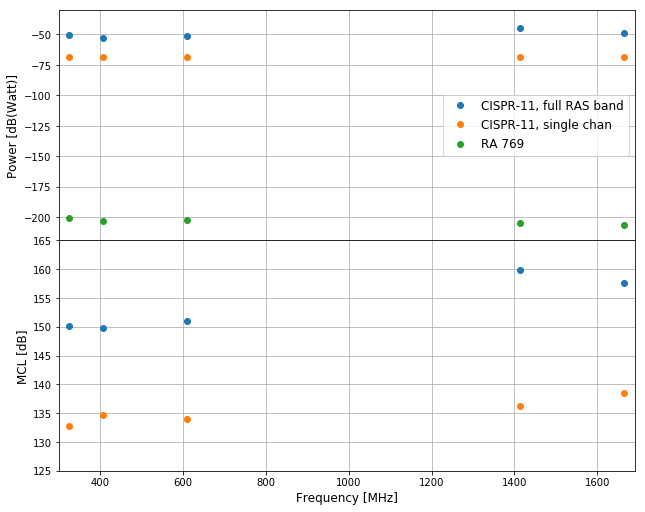

In [9]:
plt.close()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_axes((0.1, 0.5, 0.8, 0.4))
ax2 = fig.add_axes((0.1, 0.1, 0.8, 0.4))
ax1.plot(freqs, cispr11_pow_lim_2.to(cnv.dB_W), 'o', label='CISPR-11, full RAS band')
ax1.plot(freqs, cispr11_pow_lim_1.to(cnv.dB_W), 'o', label='CISPR-11, single chan')
ax1.plot(freqs, ra769_tab_db['Plim'].data, 'o', label='RA 769')
ax2.plot(freqs, MCL_2.to(cnv.dB), 'o', label='CISPR-11, full RAS band')
ax2.plot(freqs, MCL_1.to(cnv.dB), 'o', label='CISPR-11, single chan')
ax1.legend(*ax1.get_legend_handles_labels(), loc='center right', numpoints=1, fontsize=12)
for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlim((301, 1690))

ax1.tick_params(axis='x', which='both', labelbottom='off')
ax2.set_xlabel('Frequency [MHz]', fontsize=12)
ax1.set_ylabel('Power [dB(Watt)]', fontsize=12)
ax2.set_ylabel('MCL [dB]', fontsize=12)
ax1.set_ylim((-219, -30))
ax2.set_ylim((125, 165))
plt.show()

It can be seen, that the CISPR-11 levels refer to relatively high permitted transmission power levels. As a consequence, the MCL is large.

## Path attenuation and separation distances
Calculating the path propagation loss is fairly simple with pycraf, and since it has been explained in the other notebooks in detail, we will just post the necessary code without much explanation here.

In this notebook, we'll start with a generic (aka flat-Earth) analysis. In [the next notebook](https://github.com/bwinkel/pycraf/blob/master/notebooks/B02_wind_turbine_terrain.ipynb) a site-specific study is performed. For this example, we will look at the 610 MHz band.

In [10]:
MCL_610 = MCL_2[2]  # 2nd scenario (full RAS band) as worst-case
print('MCL: {:.1f}'.format(MCL_610))

MCL: 150.9 dB


In [11]:
# define dummy coordinates
lon_t, lon_r = 0 * u.deg, 0 * u.deg
lat_t, lat_r = 50 * u.deg, 50 * u.deg
h_tg, h_rg = 160 * u.m, 50 * u.m  # Tx and Rx are well above clutter

frequency = 610 * u.MHz  # choose any frequency, you like
temperature = 293.15 * u.K
pressure = 1013. * u.hPa

time_percent = 2 * u.percent
hprof_step = 30 * u.m

In [12]:
hprof_data = pathprof.height_path_data_generic(
    200 * u.km, hprof_step, 0. * u.deg, lat_t,
    )
distances = hprof_data['distances']

results = pathprof.atten_path_fast(
    frequency, temperature, pressure,
    h_tg, h_rg,
    time_percent,
    hprof_data,
    )


In [13]:
# look at path attenuation as a function of distance

attens = np.zeros(
    distances.shape, 
    dtype=np.dtype([
        ('LOS', 'f8'), ('Diffraction', 'f8'), ('Troposcatter', 'f8'), 
        ('Ducting', 'f8'), ('Total', 'f8')
        ])
    )

for fname, k in zip(
        attens.dtype.names,
        ['L_b0p', 'L_bd', 'L_bs', 'L_ba', 'L_b']
        ):
    attens[fname] = results[k]

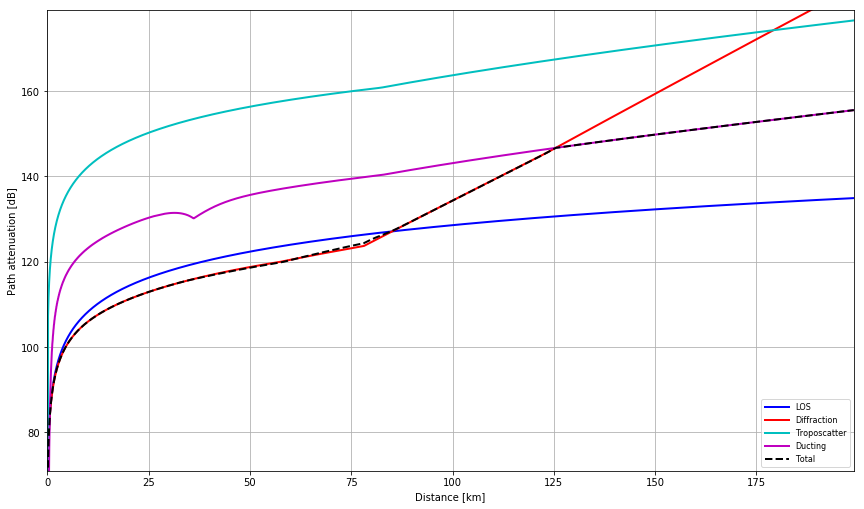

In [14]:
plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for (name, style) in zip(
        attens.dtype.names, 
        ['b-', 'r-', 'c-', 'm-', 'k--']
        ):
    ax.plot(distances, attens[name], style, label=name, lw=2)

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.set_xlim((0, 199))
ax.set_ylim((71, 179))
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Path attenuation [dB]')
ax.grid()
plt.show()

The path attenuation is very sensitive to the wind turbine hub height:

In [15]:
heights = [80, 120, 160, 200]
attens_dict = {}

for _h_tg in heights:
    
    results = pathprof.atten_path_fast(
        frequency, temperature, pressure,
        _h_tg * u.m, h_rg,
        time_percent,
        hprof_data,
        )
    
    attens_dict[_h_tg] = results['L_b']

Plotting the margin tells us, how large the necessary separation distance would need to be:

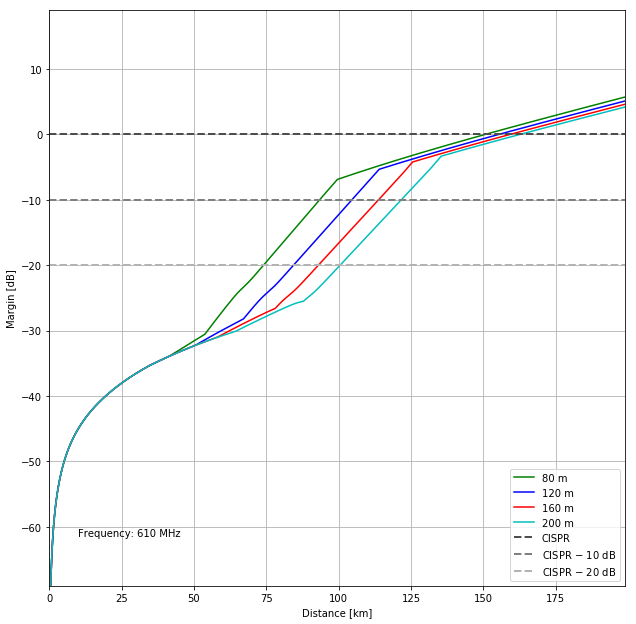

In [16]:
plt.close()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for _h_tg, style in zip(heights, ['g-', 'b-', 'r-', 'c-']):
    ax.plot(
        distances,
        -MCL_610.to(cnv.dB).value + attens_dict[_h_tg].to(cnv.dB).value,
        style, label='{:d} m'.format(_h_tg)
        )

ax.axhline(0., c='0.3', ls='--', lw=2, label='CISPR')
ax.axhline(-10., c='0.5', ls='--', lw=2, label='CISPR $-$ 10 dB')
ax.axhline(-20., c='0.7', ls='--', lw=2, label='CISPR $-$ 20 dB')
# ax.axvline(P_lim, c='r', lw=2, ls='--', label='RA.769')
ax.legend(*ax.get_legend_handles_labels(), loc='lower right')
ax.set_xlim((0, 199))
ax.set_ylim((-69, 19))
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Margin [dB]')
ax.text(
    0.05, 0.1, 'Frequency: {:.0f}'.format(frequency), 
    va='top', ha='left', transform=ax.transAxes
    )
ax.grid()
plt.show()

So, if the CISPR-11 levels were used to the maximum, the necessary protection zone would need to have a radius of about 150 km! If the wind turbine's emission would fall 20 dB below CISPR-11 levels, the zero-margin lies at about 75-100 km separation, depending on the hub height.